In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import numpy  as np
import pandas as pd
import random

from sklearn import datasets
from scipy.spatial.distance import cdist #считает пространственную 

#Инициализируем датасет


In [2]:
iris = datasets.load_iris()
trainX = iris.data
trainY = iris.target

In [3]:
testX = []
testY = []

#забираем 15 штук на валидацию, выбрал рандомно
indexes = [42, 25, 98, 50, 136, 113, 90, 118, 7, 81, 114, 128, 46, 103, 63]

for index in indexes:
  testX.append(trainX[index])
  testY.append(trainY[index])

trainX = np.delete(trainX, indexes, axis=0)
trainY = np.delete(trainY, indexes, axis=0)

In [9]:
testX = np.array(testX)
testY = np.array(testY)

#Визуализируем данные

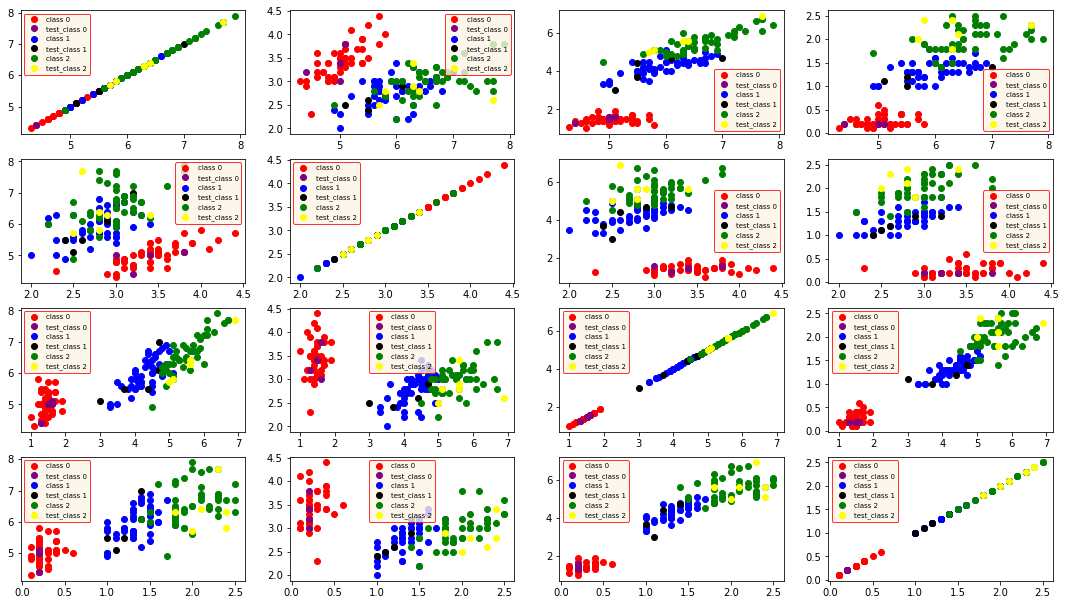

In [10]:
fig, axs = plt.subplots(nrows=4, ncols=4)

colors = ['red', 'blue', 'green']
test_colors = ['purple', 'black', 'yellow']

for i in range(4):
    for j in range(4):
        for k in np.unique(trainY):
            axs[i%4, j%4].plot(trainX[trainY==k, i], trainX[trainY==k, j], 'o', label='class {}'.format(k), color = colors[k])
            axs[i%4, j%4].plot(testX[testY==k, i], testX[testY==k, j], 'o', label='test_class {}'.format(k), color = test_colors[k])
            axs[i%4, j%4].legend(fontsize=7, ncol=1, facecolor='oldlace', edgecolor='r')

fig.set_size_inches(18.5, 10.5)
plt.show()
plt.close()

#Метод потенциальных функций без ядра


In [ ]:
class PFM_nokernel(object):

    
    def __init__(self)->None:
        self.X, self.Y, self.gams = None, None, None
    

    def _calc_dist(self, x, matrix) -> np.array:
        """
        Используем Евклидову метрику
        """
        distance = []

        for item in matrix:
            d = 0
            for i in range(len(x)):
                d += (x[i] - item[i])**2
            distance.append(1./(1. + d**(0.5)))
        return np.array(distance)

    def predict(self, x)->None:

        distances = self._calc_dist(x, self.X)
        features = self.gams * distances  # self.kernel(distances)
        class0, class1, class2 = 0, 0, 0

        scores = np.vstack(
            [np.sum(features.T[np.where(self.Y==0)[0]].T, axis=-1),
            np.sum(features.T[np.where(self.Y==1)[0]].T, axis=-1),
            np.sum(features.T[np.where(self.Y==2)[0]].T, axis=-1)]).T
    
        return np.argmax(scores, axis=-1)[0]

    def fit(self, X: np.array, Y: np.array, epochs: int)->None:

        self.X, self.Y, self.gams = X, Y, np.zeros_like(Y)
        
        for _ in range(epochs):
            for i in range(len(self.Y)):
                if self.predict(self.X[i]) != self.Y[i]:
                    self.gams[i] += 1

    def fit_non_zero(self, X: np.array, Y: np.array, epochs: int, starter: int)->None:

        self.X, self.Y, self.gams = X, Y, np.zeros_like(Y) + starter
        
        for _ in range(epochs):
            for i in range(len(self.Y)):
                if self.predict(self.X[i]) != self.Y[i]:
                    self.gams[i] += 1

    def increase_gams(self, increaser: int):
        self.gams += increaser
    

#Метод потенциальных функций с ядром

In [24]:
from scipy.spatial import distance
class PFM(object):
 
    def __init__(self, kernel=None)->None:
        self.X, self.Y, self.gams = None, None, None
        self.kernel = lambda x: np.ones_like(x)
        if kernel is not None:
            self.kernel = kernel

    def get_gams(self) -> np.array:
        if self.gams is None:
            return np.ones_like(self.X)
        else:
            return self.gams

    def _calc_distances(self, XA, XB):
        """
        размер массива расстояний: если в XA - n строк, а в XB m строк -> (n, m)
        """
        distance = np.sqrt(np.sum((XA.T - XB.T)**2, axis=0))
        return np.array(distance)


    def scores(self, X) -> np.array:
        # features = self.gams * self.kernel(cdist(X, self.X))
        features = self.gams * self.kernel(self._calc_distances(XA=X, XB=self.X))
        scores = np.vstack(
            [np.sum(features.T[np.where(self.Y==0)[0]].T, axis=-1),
            np.sum(features.T[np.where(self.Y==1)[0]].T, axis=-1),
            np.sum(features.T[np.where(self.Y==2)[0]].T, axis=-1)]).T
        return scores

    def predict(self, X):
        return np.argmax(self.scores(X), axis=-1)

    def fit(self, X: np.array, Y: np.array, epochs: int)->None:

        self.X, self.Y, self.gams = X, Y, np.zeros_like(Y)
        
        for _ in range(epochs):
            for i, (x, y) in enumerate(zip(self.X, self.Y)):
                if self.predict(np.array([x]))[0] != y:
                    self.gams[i] += 1

    def fit_non_zero(self, X: np.array, Y: np.array, epochs: int, starter: int)->None:

        self.X, self.Y, self.gams = X, Y, np.zeros_like(Y) + starter
        
        for _ in range(epochs):
            for i, (x, y) in enumerate(zip(self.X, self.Y)):
                if self.predict(np.array([x]))[0] != y:
                    self.gams[i] += 1

    def increase_gams(self, increaser: int):
        self.gams += increaser

In [12]:
def K(distance, h=0.05):
    ret = np.array(distance)/h
    return (1 - ret**2) * (np.abs(ret) <= 1)

In [13]:
def K1(distance, h=0.05):
    ret = np.array(distance)/h
    return (1./(ret + 1.)) * (np.abs(ret) <= 1)

#Тренируем модель

**без ядра**

In [ ]:
model = PFM_nokernel()  # kernel = lambda x: K(x)
model.fit(trainX, trainY, 200)

In [ ]:
counter = 0

for i in range(len(testX)):
    print(f'predict: {model.predict(np.array(testX[i]))} \t ground t: {testY[i]}')
    if model.predict(testX[i]) == testY[i]:
        counter += 1

print(f'Accuracy on test:   {counter/len(testX)}')

predict: 0 	 ground t: 0
predict: 0 	 ground t: 0
predict: 1 	 ground t: 1
predict: 1 	 ground t: 1
predict: 2 	 ground t: 2
predict: 2 	 ground t: 2
predict: 1 	 ground t: 1
predict: 2 	 ground t: 2
predict: 0 	 ground t: 0
predict: 1 	 ground t: 1
predict: 2 	 ground t: 2
predict: 2 	 ground t: 2
predict: 0 	 ground t: 0
predict: 2 	 ground t: 2
predict: 1 	 ground t: 1
Accuracy on test:   1.0


**с ядром**

In [14]:
def calc_accuracy(model, X, Y) -> float:
    counter = 0

    for i, (x, y) in enumerate(zip(testX, testY)):
        prediction = model.predict(np.array([x]))[0]
        if prediction == y:
            counter += 1

    print(f'Accuracy on test with h={h}:   {counter/len(testX)}')
    return counter/len(testX)

In [15]:
def calc_accuracy_with_predictions(model, X, Y):
    counter = 0

    for i, (x, y) in enumerate(zip(testX, testY)):
        prediction = model.predict(np.array([x]))[0]
        print(f'predict: {prediction} \t ground t: {testY[i]}')
        if prediction == y:
            counter += 1

    print(f'Accuracy on test:   {counter/len(testX)}')

In [16]:
model = PFM(kernel=lambda x: K1(x, h=4.0))
model.fit(trainX, trainY, 100)
calc_accuracy_with_predictions(model=model, X=testX, Y=testY)

predict: 0 	 ground t: 0
predict: 0 	 ground t: 0
predict: 1 	 ground t: 1
predict: 1 	 ground t: 1
predict: 2 	 ground t: 2
predict: 2 	 ground t: 2
predict: 1 	 ground t: 1
predict: 2 	 ground t: 2
predict: 0 	 ground t: 0
predict: 1 	 ground t: 1
predict: 2 	 ground t: 2
predict: 2 	 ground t: 2
predict: 0 	 ground t: 0
predict: 2 	 ground t: 2
predict: 1 	 ground t: 1
Accuracy on test:   1.0


Accuracy on test with h=0.05:   0.26666666666666666
Accuracy on test with h=0.1:   0.26666666666666666
Accuracy on test with h=0.5:   0.8666666666666667
Accuracy on test with h=1.0:   0.9333333333333333
Accuracy on test with h=2.0:   0.8666666666666667
Accuracy on test with h=10.0:   1.0


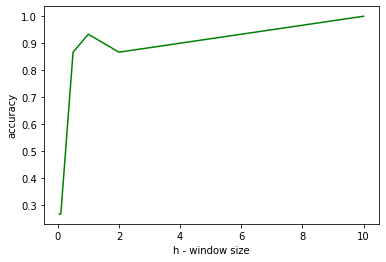

In [17]:
accuracy_val = []
h_val = [0.05, 0.1, 0.5, 1.0, 2.0, 10.0]
for h in [0.05, 0.1, 0.5, 1.0, 2.0, 10.0]:
    model = PFM(kernel=lambda x: K1(x, h=h))
    model.fit(trainX, trainY, 100)
    accuracy_val.append(calc_accuracy(model=model, X=testX, Y=testY))

plt.plot(h_val, accuracy_val, label='accuracy', color='green')
plt.xlabel('h - window size')
plt.ylabel('accuracy')
plt.show()
plt.close()

#Кроссвалидация


In [26]:
iris = datasets.load_iris()
x = np.array(iris.data)
y = np.array(iris.target)
trainY, trainX = [], []

indexes = np.random.permutation(len(y))

for i in range(len(y)):
    trainY.append(y[indexes[i]])
    trainX.append(x[indexes[i]])

trainX = np.array(trainX)
trainY = np.array(trainY)

In [27]:
K=5  # кол-во подвыборок
# print(len(y))

for h in [0.05, 0.1, 0.5, 1.0, 2.0, 10.0]:
    print(f'h={h}: \n')
    X = np.array_split(trainX, K, axis=0)
    Y = np.array_split(trainY, K, axis=0)

    accuracy_counter = 0

    for k in range(K):
        print(f'k={k}')
        subX, subY = None, None
        for i in range(K):
            if i != k:
                if subX is not None:
                    subX = np.vstack([subX, X[i]])
                else:
                    subX = X[i]
                if subY is not None:
                    subY = np.hstack([subY, Y[i]])
                else:
                    subY = Y[i]
                # print(subY)

        model = PFM(kernel=lambda x: K1(x, h=h))
        model.fit(subX, subY, 50)
        accuracy_counter += calc_accuracy(model=model, X=X[i], Y=Y[i])
    print(f'average accuracy = {accuracy_counter/K}\n\n')


h=0.05: 

k=0
Accuracy on test with h=0.05:   0.8666666666666667
k=1
Accuracy on test with h=0.05:   0.8
k=2
Accuracy on test with h=0.05:   1.0
k=3
Accuracy on test with h=0.05:   0.6666666666666666
k=4
Accuracy on test with h=0.05:   0.9333333333333333
average accuracy = 0.8533333333333333


h=0.1: 

k=0
Accuracy on test with h=0.1:   0.8666666666666667
k=1
Accuracy on test with h=0.1:   0.8
k=2
Accuracy on test with h=0.1:   1.0
k=3
Accuracy on test with h=0.1:   0.6666666666666666
k=4
Accuracy on test with h=0.1:   0.9333333333333333
average accuracy = 0.8533333333333333


h=0.5: 

k=0
Accuracy on test with h=0.5:   0.9333333333333333
k=1
Accuracy on test with h=0.5:   1.0
k=2
Accuracy on test with h=0.5:   1.0
k=3
Accuracy on test with h=0.5:   0.9333333333333333
k=4
Accuracy on test with h=0.5:   0.9333333333333333
average accuracy = 0.9600000000000002


h=1.0: 

k=0
Accuracy on test with h=1.0:   0.9333333333333333
k=1
Accuracy on test with h=1.0:   0.9333333333333333
k=2
Accura

In [28]:
model.gams

array([0, 0, 1, 1, 1, 0, 0, 2, 2, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 4, 0, 1, 3, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 5, 5, 2, 0, 0, 0, 0,
       0, 0, 2, 2, 2, 1, 1, 0, 0, 0, 2, 2, 0, 0, 0, 1, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

**Показать элементы с ненулевым потенциалом**

In [29]:
model = PFM(kernel=lambda x: K1(x, h=1.0))
model.fit(trainX, trainY, 30)
calc_accuracy_with_predictions(model=model, X=testX, Y=testY)

predict: 0 	 ground t: 0
predict: 0 	 ground t: 0
predict: 1 	 ground t: 1
predict: 1 	 ground t: 1
predict: 2 	 ground t: 2
predict: 2 	 ground t: 2
predict: 1 	 ground t: 1
predict: 2 	 ground t: 2
predict: 0 	 ground t: 0
predict: 1 	 ground t: 1
predict: 2 	 ground t: 2
predict: 2 	 ground t: 2
predict: 0 	 ground t: 0
predict: 2 	 ground t: 2
predict: 1 	 ground t: 1
Accuracy on test:   1.0


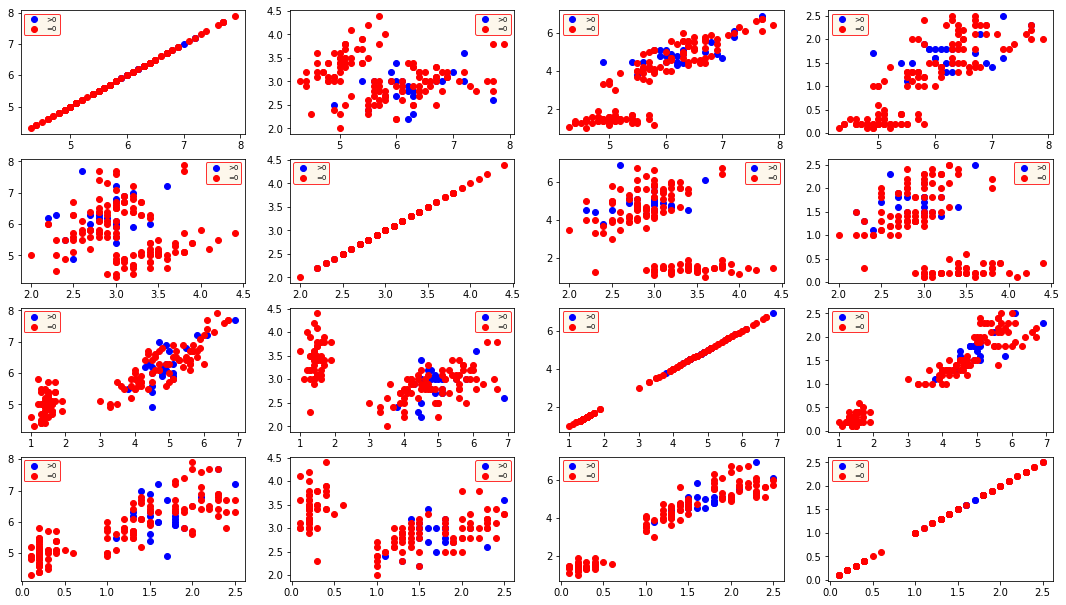

In [30]:
fig, axs = plt.subplots(nrows=4, ncols=4)

colors = ['red', 'blue', 'green']
test_colors = ['purple', 'black', 'yellow']

gams = model.gams

for i in range(4):
    for j in range(4):
            axs[i%4, j%4].scatter(trainX[np.where(gams!= 0)[0], i], trainX[np.where(gams!= 0)[0], j], color = colors[1], label='>0')
            axs[i%4, j%4].scatter(trainX[np.where(gams== 0)[0], i], trainX[np.where(gams== 0)[0], j], color = colors[0], label='=0')
            axs[i%4, j%4].legend(fontsize=7, ncol=1, facecolor='oldlace', edgecolor='r')
fig.set_size_inches(18.5, 10.5)
plt.show()
plt.close()

##Что если после обучения увеличить потенциал? сделать ненулевым

In [31]:
model.increase_gams(1)
model = PFM(kernel=lambda x: K1(x, h=1.0))
model.fit(trainX, trainY, 30)
calc_accuracy_with_predictions(model=model, X=testX, Y=testY)

predict: 0 	 ground t: 0
predict: 0 	 ground t: 0
predict: 1 	 ground t: 1
predict: 1 	 ground t: 1
predict: 2 	 ground t: 2
predict: 2 	 ground t: 2
predict: 1 	 ground t: 1
predict: 2 	 ground t: 2
predict: 0 	 ground t: 0
predict: 1 	 ground t: 1
predict: 2 	 ground t: 2
predict: 2 	 ground t: 2
predict: 0 	 ground t: 0
predict: 2 	 ground t: 2
predict: 1 	 ground t: 1
Accuracy on test:   1.0
